In [21]:
import os
import xml.etree.ElementTree as ET
import cv2

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    
    for obj in root.findall('object'):
        defect_type = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        
        x_center = (xmin + xmax) / 2.0 / width
        y_center = (ymin + ymax) / 2.0 / height
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height
        
        annotations.append([defect_type, x_center, y_center, bbox_width, bbox_height])
    return annotations
# missing_hole=0, mouse=1, open=2, short=3, spur=4, spurious=5
def save_yolo_format(annotations, output_file):
    with open(output_file, 'w') as f:
        for annotation in annotations:
            defect_type, x_center, y_center, bbox_width, bbox_height = annotation
            f.write(f"0 {x_center} {y_center} {bbox_width} {bbox_height}\n")


# 設定XML檔案資料夾和輸出YOLO標註檔案資料夾
xml_folder = 'xml_datasets/val/Annotations/Spurious_copper'
output_folder = 'datasets/val/Annotations/Spurious_copper'

os.makedirs(output_folder, exist_ok=True)

# 處理每個XML檔案
for xml_file in os.listdir(xml_folder):
    if xml_file.endswith('.xml'):
        xml_path = os.path.join(xml_folder, xml_file)
        annotations = parse_annotation(xml_path)
        
        output_file = os.path.join(output_folder, os.path.splitext(xml_file)[0] + '.txt')
        save_yolo_format(annotations, output_file)


## 確認yolo標註

OD_dataset/val/images/09_spurious_copper_06_crop_0.png


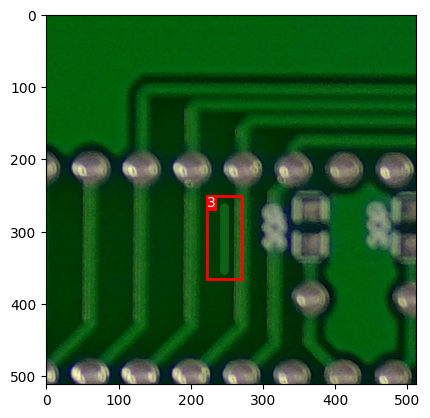

OD_dataset/val/images/09_short_02_crop_2.png


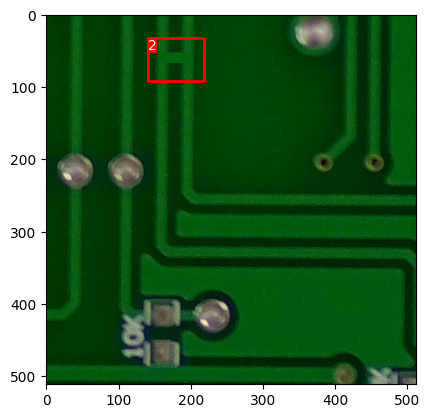

OD_dataset/val/images/10_mouse_bite_02_crop_5.png


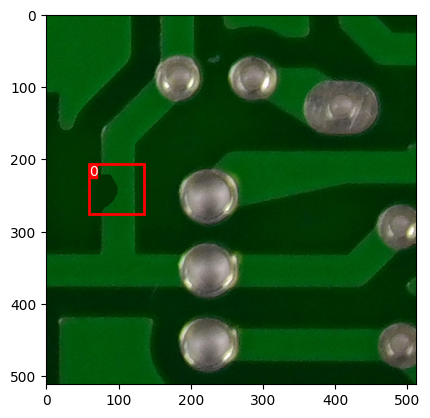

OD_dataset/val/images/09_short_03_crop_1.png


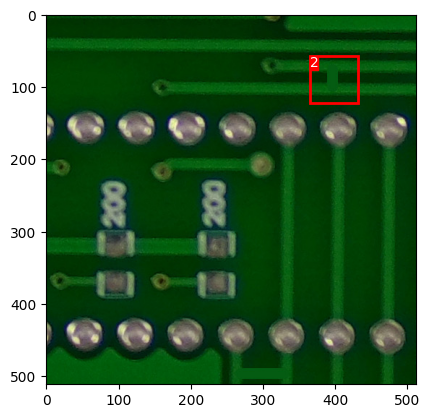

OD_dataset/val/images/09_missing_hole_06_crop_3.png


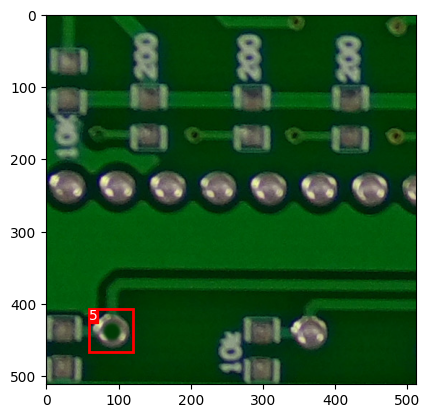

OD_dataset/val/images/09_mouse_bite_03_crop_0.png


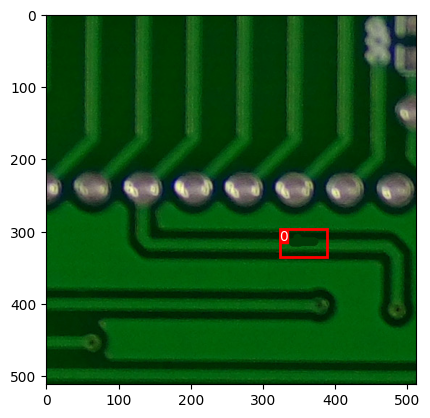

OD_dataset/val/images/10_missing_hole_04_crop_4.png


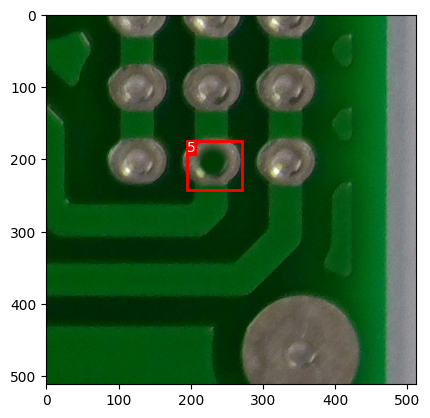

OD_dataset/val/images/09_spurious_copper_07_crop_4.png


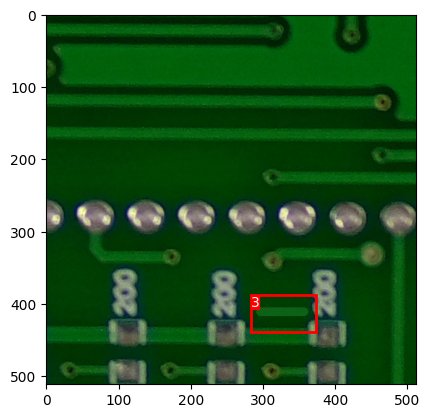

OD_dataset/val/images/09_open_circuit_01_crop_4.png


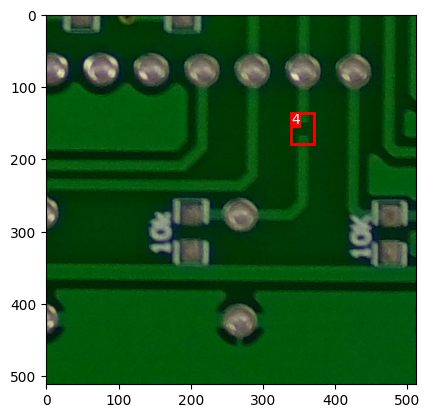

OD_dataset/val/images/09_spurious_copper_09_crop_0.png


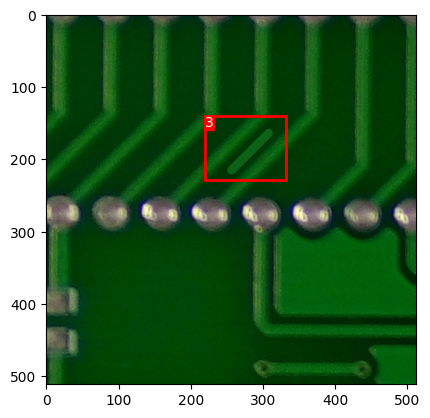

In [18]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def plot_image_with_boxes(image_path, label_path):
    # 讀取圖片
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 讀取YOLO標注格式檔案
    with open(label_path, 'r') as f:
        labels = f.readlines()
    height, width, _ = image.shape

    # 創建matplotlib圖像
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # 處理每個標注
    for label in labels:
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.strip().split())
        
        # YOLO標注格式是相對座標，需要轉換為絕對座標
        x_center *= width
        y_center *= height
        bbox_width *= width
        bbox_height *= height
        
        # 計算左上角座標
        x_min = x_center - bbox_width / 2
        y_min = y_center - bbox_height / 2
        
        # 創建矩形標注框
        rect = patches.Rectangle((x_min, y_min), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # 可以在這裡添加標籤名稱
        plt.text(x_min, y_min, str(int(class_id)), color='white', verticalalignment='top', bbox={'color': 'red', 'pad': 0})

    # 顯示圖片
    plt.show()

# 設定圖片資料夾和標注檔案資料夾
image_folder = 'OD_dataset/val/images'
label_folder = 'OD_dataset/val/labels'

# 獲取所有圖片文件
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]

# 隨機選擇10張圖片
random_image_files = random.sample(image_files, min(10, len(image_files)))

# 處理隨機選擇的每張圖片及其相應的標注檔案
for image_file in random_image_files:
    image_path = os.path.join(image_folder, image_file)
    label_path = os.path.join(label_folder, os.path.splitext(image_file)[0] + '.txt')
    
    if os.path.exists(label_path):
        print(image_path)
        plot_image_with_boxes(image_path, label_path)

## for classification no use

In [7]:
import cv2
import numpy as np
import random
import os

def read_annotations(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    annotations = []
    for line in lines:
        annotations.append([float(num) for num in line.strip().split()])
    return annotations

def is_overlap(x1, y1, x2, y2, annotations, w, h):
    for _, x, y, bw, bh in annotations:
        ann_x1 = int((x - bw / 2) * w)
        ann_y1 = int((y - bh / 2) * h)
        ann_x2 = int((x + bw / 2) * w)
        ann_y2 = int((y + bh / 2) * h)
        if not (x2 <= ann_x1 or x1 >= ann_x2 or y2 <= ann_y1 or y1 >= ann_y2):
            return True
    return False

def save_cropped_images(image, annotations, output_dir, image_name):
    h, w, _ = image.shape
    crop_size = 512
    base_name = os.path.splitext(image_name)[0]
    for i, (cls, x, y, bw, bh) in enumerate(annotations):
        #for j in range(5):  # 取5次偏移
            offset_x = random.randint(-200, 200)
            offset_y = random.randint(-200, 200)
            cx = int(x * w) + offset_x
            cy = int(y * h) + offset_y

            # 確保裁剪區域不超出圖片邊界
            cx = max(crop_size // 2, min(cx, w - crop_size // 2))
            cy = max(crop_size // 2, min(cy, h - crop_size // 2))

            # 計算裁剪區域的邊界
            x1 = cx - crop_size // 2
            y1 = cy - crop_size // 2
            x2 = cx + crop_size // 2
            y2 = cy + crop_size // 2

            # 確保裁剪區域不超出圖片邊界
            if x1 < 0 or y1 < 0 or x2 > w or y2 > h:
                continue

            crop_img = image[y1:y2, x1:x2]
            cv2.imwrite(os.path.join(output_dir, f"{base_name}_crop_{i}.png"), crop_img)

def save_background_images(image, annotations, output_dir, image_name):
    h, w, _ = image.shape
    crop_size = 512
    num_backgrounds = int(len(annotations))
    base_name = os.path.splitext(image_name)[0]
    for i in range(num_backgrounds):  # 根據標註數量生成背景圖片
        while True:
            x1 = random.randint(0, w - crop_size)
            y1 = random.randint(0, h - crop_size)
            x2 = x1 + crop_size
            y2 = y1 + crop_size

            overlap = is_overlap(x1, y1, x2, y2, annotations, w, h)
            if not overlap:
                crop_img = image[y1:y2, x1:x2]
                cv2.imwrite(os.path.join(output_dir, f"{base_name}_background_{i}.png"), crop_img)
                break

# 設定主資料夾路徑
main_folders = ['test', 'train', 'val']
base_path = 'yolo_datasets/'

for main_folder in main_folders:
    image_folder = os.path.join(base_path, main_folder, 'images')
    annotation_folder = os.path.join(base_path, main_folder, 'Annotations')
    output_folder = os.path.join('classifications_dataset', main_folder)

    # 建立輸出資料夾
    os.makedirs(output_folder, exist_ok=True)
    print(f"Created output folder: {output_folder}")

    # 遍歷所有類別資料夾
    for category in os.listdir(image_folder):
        image_category_folder = os.path.join(image_folder, category)
        annotation_category_folder = os.path.join(annotation_folder, category)
        output_category_folder = os.path.join(output_folder, category)

        # 確保是資料夾
        if not os.path.isdir(image_category_folder): #debug ".DS_store"
            continue

        # 建立類別輸出資料夾
        os.makedirs(output_category_folder, exist_ok=True)
        print(f"Created category output folder: {output_category_folder}")

        # 讀取類別資料夾中的所有圖片檔案
        image_files = [f for f in os.listdir(image_category_folder) if f.endswith('.jpg')]

        for image_file in image_files:
            # 讀取圖片
            image_path = os.path.join(image_category_folder, image_file)
            image = cv2.imread(image_path)
            print(f"Processing image: {image_path}")
            # 對應的標註文件
            annotation_file = os.path.splitext(image_file)[0] + '.txt'
            annotation_path = os.path.join(annotation_category_folder, annotation_file)
            # 讀取標註
            annotations = read_annotations(annotation_path)
            # 儲存裁剪的圖片
            save_cropped_images(image, annotations, output_category_folder, image_file)
            # 儲存背景圖片
            save_background_images(image, annotations, output_category_folder, image_file)

Created output folder: classifications_dataset/test
Created category output folder: classifications_dataset/test/Mouse_bite
Processing image: yolo_datasets/test/images/Mouse_bite/11_mouse_bite_06.jpg
Processing image: yolo_datasets/test/images/Mouse_bite/11_mouse_bite_07.jpg
Processing image: yolo_datasets/test/images/Mouse_bite/11_mouse_bite_05.jpg
Processing image: yolo_datasets/test/images/Mouse_bite/11_mouse_bite_10.jpg
Processing image: yolo_datasets/test/images/Mouse_bite/11_mouse_bite_04.jpg
Processing image: yolo_datasets/test/images/Mouse_bite/11_mouse_bite_01.jpg
Processing image: yolo_datasets/test/images/Mouse_bite/11_mouse_bite_03.jpg
Processing image: yolo_datasets/test/images/Mouse_bite/11_mouse_bite_02.jpg
Processing image: yolo_datasets/test/images/Mouse_bite/12_mouse_bite_01.jpg
Processing image: yolo_datasets/test/images/Mouse_bite/12_mouse_bite_03.jpg
Processing image: yolo_datasets/test/images/Mouse_bite/12_mouse_bite_02.jpg
Processing image: yolo_datasets/test/ima

KeyboardInterrupt: 

## for object detection

In [15]:
import cv2
import numpy as np
import random
import os

def read_annotations(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    annotations = []
    for line in lines:
        annotations.append([float(num) for num in line.strip().split()])
    return annotations

def is_overlap(x1, y1, x2, y2, annotations, w, h):
    for _, x, y, bw, bh in annotations:
        ann_x1 = int((x - bw / 2) * w)
        ann_y1 = int((y - bh / 2) * h)
        ann_x2 = int((x + bw / 2) * w)
        ann_y2 = int((y + bh / 2) * h)
        if not (x2 <= ann_x1 or x1 >= ann_x2 or y2 <= ann_y1 or y1 >= ann_y2):
            return True
    return False

def save_cropped_images(image, annotations, output_image_folder, output_label_folder, image_name):
    h, w, _ = image.shape
    crop_size = 512
    base_name = os.path.splitext(image_name)[0]
    
    for i, (cls, x, y, bw, bh) in enumerate(annotations):
        offset_x = random.randint(-200, 200)
        offset_y = random.randint(-200, 200)
        cx = int(x * w) + offset_x
        cy = int(y * h) + offset_y

        # 確保裁剪區域不超出圖片邊界
        cx = max(crop_size // 2, min(cx, w - crop_size // 2))
        cy = max(crop_size // 2, min(cy, h - crop_size // 2))

        # 計算裁剪區域的邊界
        crop_x1 = cx - crop_size // 2
        crop_y1 = cy - crop_size // 2
        crop_x2 = cx + crop_size // 2
        crop_y2 = cy + crop_size // 2

        # 確保裁剪區域不超出圖片邊界
        if crop_x1 < 0 or crop_y1 < 0 or crop_x2 > w or crop_y2 > h:
            continue

        crop_img = image[crop_y1:crop_y2, crop_x1:crop_x2]
        crop_annotations = []
        for cls2, x2, y2, bw2, bh2 in annotations: #找到是哪一個原圖標記
            ann_x_center = int(x2 * w)
            ann_y_center = int(y2 * h)
            ann_bw = int(bw2 * w)
            ann_bh = int(bh2 * h)
            ann_x1 = ann_x_center - ann_bw // 2
            ann_y1 = ann_y_center - ann_bh // 2
            ann_x2 = ann_x_center + ann_bw // 2
            ann_y2 = ann_y_center + ann_bh // 2
            # ann 是原始圖片的絕對框位置, crop 是擷取的原圖絕對位置
            # check 擷取位置中是否有標註 若有，轉換成針對512 * 512 的大小
            if crop_x1 <= ann_x1 <= crop_x2 and crop_x1 <= ann_x2 <= crop_x2 and crop_y1 <= ann_y1 <= crop_y2 and crop_y1 <= ann_y2 <= crop_y2:
                new_x = (ann_x_center - crop_x1) / crop_size
                new_y = (ann_y_center - crop_y1) / crop_size
                new_bw = bw2 * w / crop_size
                new_bh = bh2 * h / crop_size
                crop_annotations.append([cls2, new_x, new_y, new_bw, new_bh])
        
        # 保存裁剪图片和对应的标注
        if crop_annotations:
            crop_image_path = os.path.join(output_image_folder, f"{base_name}_crop_{i}.png")
            cv2.imwrite(crop_image_path, crop_img)
            print(f"Saved cropped image: {crop_image_path}")
            with open(os.path.join(output_label_folder, f"{base_name}_crop_{i}.txt"), 'w') as f:
                for ann in crop_annotations:
                    f.write(' '.join(map(str, ann)) + '\n')


# OD no need BG
# def save_background_images(image, annotations, output_dir, image_name):
#     h, w, _ = image.shape
#     crop_size = 512
#     num_backgrounds = int(len(annotations))
#     base_name = os.path.splitext(image_name)[0]
#     for i in range(num_backgrounds):
#         while True:
#             x1 = random.randint(0, w - crop_size)
#             y1 = random.randint(0, h - crop_size)
#             x2 = x1 + crop_size
#             y2 = y1 + crop_size

#             overlap = is_overlap(x1, y1, x2, y2, annotations, w, h)
#             if not overlap:
#                 crop_img = image[y1:y2, x1:x2]
#                 cv2.imwrite(os.path.join(output_dir, f"{base_name}_background_{i}.png"), crop_img)
#                 with open(os.path.join(output_dir, f"{base_name}_background_{i}.txt"), 'w') as f:
#                     f.write('')
#                 break

# 主程序設定
main_folders = ['test', 'train', 'val']
base_path = 'yolo_datasets/'

# 初始化類別字典
class_dict = {}
class_counter = 0

for main_folder in main_folders:
    image_folder = os.path.join(base_path, main_folder, 'images')
    annotation_folder = os.path.join(base_path, main_folder, 'Annotations')
    output_image_folder = os.path.join('OD_dataset', main_folder, 'images')
    output_label_folder = os.path.join('OD_dataset', main_folder, 'labels')

    os.makedirs(output_image_folder, exist_ok=True)
    os.makedirs(output_label_folder, exist_ok=True)
    print(f"Created output folders: {output_image_folder} and {output_label_folder}")

    for category in os.listdir(image_folder):
        image_category_folder = os.path.join(image_folder, category)
        annotation_category_folder = os.path.join(annotation_folder, category)

        if not os.path.isdir(image_category_folder): # 確保是資料夾, #debug ".DS_store"
            continue

        # 設置類別字典
        if category not in class_dict:
            class_dict[category] = class_counter
            class_counter += 1

        image_files = [f for f in os.listdir(image_category_folder) if f.endswith('.jpg')]

        for image_file in image_files:
            image_path = os.path.join(image_category_folder, image_file)
            image = cv2.imread(image_path)
            #print(f"Processing image: {image_path}")

            annotation_file = os.path.splitext(image_file)[0] + '.txt'
            annotation_path = os.path.join(annotation_category_folder, annotation_file)
            annotations = read_annotations(annotation_path)

            # 修改標註中的類別
            for ann in annotations:
                ann[0] = class_dict[category]

            save_cropped_images(image, annotations, output_image_folder, output_label_folder, image_file)

print(class_dict)
#{'Mouse_bite': 0, 'Spur': 1, 'Short': 2, 'Spurious_copper': 3, 'Open_circuit': 4, 'Missing_hole': 5}

Created output folders: OD_dataset/test/images and OD_dataset/test/labels
Saved cropped image: OD_dataset/test/images/11_mouse_bite_06_crop_0.png
Saved cropped image: OD_dataset/test/images/11_mouse_bite_06_crop_1.png
Saved cropped image: OD_dataset/test/images/11_mouse_bite_06_crop_2.png
Saved cropped image: OD_dataset/test/images/11_mouse_bite_06_crop_3.png
Saved cropped image: OD_dataset/test/images/11_mouse_bite_06_crop_4.png
Saved cropped image: OD_dataset/test/images/11_mouse_bite_07_crop_0.png
Saved cropped image: OD_dataset/test/images/11_mouse_bite_07_crop_1.png
Saved cropped image: OD_dataset/test/images/11_mouse_bite_07_crop_2.png
Saved cropped image: OD_dataset/test/images/11_mouse_bite_07_crop_3.png
Saved cropped image: OD_dataset/test/images/11_mouse_bite_07_crop_4.png
Saved cropped image: OD_dataset/test/images/11_mouse_bite_05_crop_0.png
Saved cropped image: OD_dataset/test/images/11_mouse_bite_05_crop_1.png
Saved cropped image: OD_dataset/test/images/11_mouse_bite_05_c

In [4]:
import os
# 設定圖片資料夾和標注檔案資料夾
image_folder = 'OD_dataset/test/images'
label_folder = 'OD_dataset/val/labels'

# 獲取所有圖片文件
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]
print(len(image_files))

604


In [6]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="/Users/hank/Documents/GitHub/ML_hw3_classification/data.yaml",
                      task='detect',
                      epochs=100, patience=30, batch=32, imgsz=512,
                      device='mps',
                      optimizer='Adam',lr0=0.001
                      )

Ultralytics YOLOv8.0.163 🚀 Python-3.9.16 torch-2.0.0 MPS (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/hank/Documents/GitHub/ML_hw3_classification/data.yaml, epochs=100, patience=30, batch=32, imgsz=512, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fal

KeyboardInterrupt: 

In [2]:
help(model.train)

Help on method train in module ultralytics.engine.model:

train(trainer=None, **kwargs) method of ultralytics.models.yolo.model.YOLO instance
    Trains the model on a given dataset.
    
    Args:
        trainer (BaseTrainer, optional): Customized trainer.
        **kwargs (Any): Any number of arguments representing the training configuration.

